# **Assignment 3 - Text Mining**
## Author: Jake Brulato
## Tuesday 5:30 - 8:15 : Kornelia

**Problem description and questions:  The dataset boo_ratings.csv has reviews of books, along with other information, submitted on Amazon.  The descriptions of the columns are given below.**

- Id: Unique ID for the book 
- Title: Book’s title 
- Price: The price of Book 
- User_id: Unique ID of the user who rates the book 
- profileName: Name of the user who rates the book 
- review/helpfulness: Helpfulness rating (normalized to between 0 and 1) 
- review/score: Rating from 0 to 5 for the book 
- review/time: Time of given review 
- review/summary: The summary of a text review 
- review/text: The full text of a review 

In [38]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import pyLDAvis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster import hierarchy

### **1. (10 pts) Preprocess the text data in each of the "review/summary" and "review/text" columns. Preprocessing should include tokenization, lowercasing, stop word removal, stemming and any other necessary steps.  Describe each of the above step in the Word document.**

In [39]:
df = pd.read_csv('book_ratings.csv')
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1593351348,Wuthering Heights,18.96,AKZ3R4NWFK6ON,"E. Gray ""musiq lovr""",0.142857,5,1260230400,Got this,Got this book version along with Romeo & Julie...
1,1578849209,Natural Atheism,14.04,A384SQPY12385,David B. Pearson,0.950000,5,1135123200,Outstanding Freethought,"Although I've pretty much always been a ""natur..."
2,0613659155,Nights In Rodanthe (Turtleback School & Librar...,19.57,A2GAP7XWBZU8QI,Eric,NaN,4,1065744000,A Decent Novel,The first book I read by Mr. Sparks was 'A Wal...
3,1590594991,Pro Apache Log4j,43.94,A2IAL7V5B0M2LZ,"Wayne Cannon ""Wayne""",1.000000,4,1174176000,Almost identical with excellent on-line material,"This is an excellent reference. However, be aw..."
4,0201328186,"Yellow Fever, Black Goddess: The Coevolution O...",15.27,A14UM7LOF20W6P,Frank,0.666667,3,907200000,Stilted prose,"While the subject of the book is fascinating, ..."


In [40]:
#Calculate the nulls and then drop them
df.isnull().sum()
#vv Comment out below this line to see the total nulls for each column vv
# df = df.dropna()
# df.info()
# print(df.isnull().sum())
# df

df.fillna(0, inplace=True)
print(df.isnull().sum())
df


Id                    0
Title                 0
Price                 0
User_id               0
profileName           0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1593351348,Wuthering Heights,18.96,AKZ3R4NWFK6ON,"E. Gray ""musiq lovr""",0.142857,5,1260230400,Got this,Got this book version along with Romeo & Julie...
1,1578849209,Natural Atheism,14.04,A384SQPY12385,David B. Pearson,0.950000,5,1135123200,Outstanding Freethought,"Although I've pretty much always been a ""natur..."
2,0613659155,Nights In Rodanthe (Turtleback School & Librar...,19.57,A2GAP7XWBZU8QI,Eric,0.000000,4,1065744000,A Decent Novel,The first book I read by Mr. Sparks was 'A Wal...
3,1590594991,Pro Apache Log4j,43.94,A2IAL7V5B0M2LZ,"Wayne Cannon ""Wayne""",1.000000,4,1174176000,Almost identical with excellent on-line material,"This is an excellent reference. However, be aw..."
4,0201328186,"Yellow Fever, Black Goddess: The Coevolution O...",15.27,A14UM7LOF20W6P,Frank,0.666667,3,907200000,Stilted prose,"While the subject of the book is fascinating, ..."
...,...,...,...,...,...,...,...,...,...,...
995,1593359799,Long Spoon Lane (Charlotte and Thomas Pitt),17.89,A2GBJQ9THOYDAJ,Michael K. Smith,1.000000,3,1209859200,"""Most [policemen] are honorable, but corruptio...",I've been annoyed for some time -- for the pas...
996,1886388172,22 Friar Street,14.95,A14OJS0VWMOSWO,Midwest Book Review,1.000000,5,1034121600,Revealing the positive side of the human condi...,22 Friar Street is an exquisitely written nove...
997,1587155443,Wendigo,12.95,A1TBPAV6UHSZIV,Linda Clark,0.000000,2,1356393600,Did not hold my interest,This is actually one of the few books that I h...
998,1564584623,Big Book of Things That Go,10.79,A3FXWOCMRX0QBC,"basketlover ""rtb""",0.000000,5,1168300800,rtbrus,This along with the train book were my son's t...


In [41]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df['review/summary'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/summary.')
    
dim()

2383 dimensions in the review/summary.


In [42]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df['review/text'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/text.')
    
dim()

24438 dimensions in the review/text.


In [43]:
# removing punctuations
df['review/summary']= df['review/summary'].str.replace(r'[^\w\s]+', '')
df['review/text']= df['review/text'].str.replace(r'[^\w\s]+', '')
df['review/text'].head()

0    Got this book version along with Romeo & Julie...
1    Although I've pretty much always been a "natur...
2    The first book I read by Mr. Sparks was 'A Wal...
3    This is an excellent reference. However, be aw...
4    While the subject of the book is fascinating, ...
Name: review/text, dtype: object

In [44]:
freq = pd.Series(' '.join(df['review/text']).split()).value_counts()[:30]
freq

the     6907
and     4393
of      4024
to      3799
a       3608
is      2415
I       2339
in      2278
that    1758
this    1489
book    1466
for     1359
it      1164
with    1021
as       936
was      885
are      855
on       842
you      830
The      724
have     700
be       693
not      678
but      664
his      596
an       522
by       522
from     490
or       482
my       479
Name: count, dtype: int64

In [45]:
freq = pd.Series(' '.join(df['review/summary']).split()).value_counts()[:30]
freq

the          124
A            110
of           107
for           88
and           84
book          80
a             77
Great         68
to            62
The           45
I             44
Good          39
in            39
Book          36
is            34
read          32
but           31
this          28
good          25
Excellent     25
great         24
Not           24
not           24
on            22
with          20
you           19
This          19
it            17
that          17
An            16
Name: count, dtype: int64

In [46]:
# convert all words to lowercase
df['review/summary'] = df['review/summary'].str.lower()
df['review/summary'].head()
df['review/text'] = df['review/text'].str.lower()
df['review/text'].head()

0    got this book version along with romeo & julie...
1    although i've pretty much always been a "natur...
2    the first book i read by mr. sparks was 'a wal...
3    this is an excellent reference. however, be aw...
4    while the subject of the book is fascinating, ...
Name: review/text, dtype: object

In [47]:
# removal of stop_words
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop = stopwords.words("english")

df['review/summary'] = df['review/summary'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))
df['review/text'] = df['review/text'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbrul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['review/summary'] = df['review/summary'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

df['review/text'] = df['review/text'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

In [49]:
freq = pd.Series(' '.join(df['review/summary']).split()).value_counts()[:30]
freq

book        136
great        94
good         66
read         52
excel        31
best         28
love         23
one          21
must         19
stori        19
wonder       17
book!        15
look         14
like         14
review       12
interest     11
amaz         11
-            11
use          11
ever         11
.            10
life         10
time         10
anoth        10
resourc       9
real          9
&             9
littl         9
need          9
new           9
Name: count, dtype: int64

In [50]:
freq = pd.Series(' '.join(df['review/text']).split()).value_counts()[:30]
freq

book      1696
read       698
one        479
like       388
would      323
love       296
mani       291
make       286
stori      284
get        275
good       261
time       256
great      256
use        254
author     232
book.      220
also       217
help       215
way        207
peopl      206
much       204
want       203
first      200
even       199
take       197
think      190
find       189
well       182
realli     182
book,      180
Name: count, dtype: int64

In [51]:
# Concatenate 'review/summary' and 'review/text' into a single column
df['combined_text'] = df['review/summary'] + ' ' + df['review/text']

# Perform frequency analysis on the combined text
freq_combined = pd.Series(' '.join(df['combined_text']).split()).value_counts()[:30]

freq_combined

book      1832
read       750
one        500
like       402
great      350
good       327
would      325
love       319
stori      303
mani       296
make       291
get        280
time       266
use        265
author     235
book.      225
help       223
also       217
way        211
peopl      210
want       209
first      207
much       206
even       206
take       204
think      195
find       193
-          190
well       188
realli     188
Name: count, dtype: int64

### **2. (7 pts) Create word clouds for each of the "review/summary" and "review/text" columns, after preprocessing. Copy and paste the word clouds outputs in the Word document. Write one-two sentences for what you can interpret from each of the two word clouds.**

Word cloud for review/summary


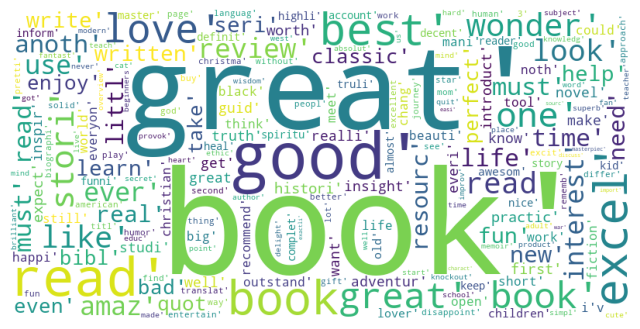

In [52]:
comment_words = str(' '.join(df['review/summary']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/summary')
plt.show()

### This word cloud seems to have a lot of positive indicators that go into muliple subjects, we see words like great/good or excel, resource or stori. I think this indicates that most of these books have a postive light thatt span multiple genres and the summarys recomend the book typically in their summary.

Word cloud for review/text


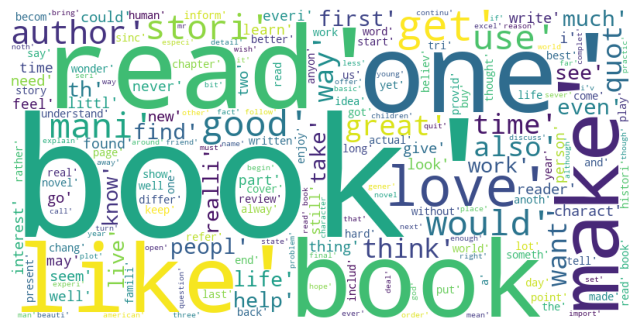

In [53]:
comment_words = str(' '.join(df['review/text']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/text')
plt.show()

### Similar to the other one, we see a lot of postive indicators with words "like" and "love". We also see other words like "one", "make", "differ" which could indicate that there is only need for one of these books from the review, making a slightly negative disposition.

### **3. (8 pts) Perform text mining for each of the "review/summary" and "review/text" columns to estimate the similarity between documents. Show the similarity output tables for the first 5 documents for the summary and text columns. Paste the appropriate screenshots in the Word document.**

In [54]:
summary_corpus = [doc.split() for doc in df["review/summary"]]
text_corpus = [doc.split() for doc in df["review/text"]]

In [55]:
sum_dictionary = corpora.Dictionary(summary_corpus)
text_dictionary = corpora.Dictionary(text_corpus)

In [56]:
sum_dictionary.filter_extremes(no_below = 2, no_above = 0.75)
text_dictionary.filter_extremes(no_below = 2, no_above = 0.75)

In [57]:
sum_DFM = [sum_dictionary.doc2bow(doc) for doc in summary_corpus]
text_DFM = [text_dictionary.doc2bow(doc) for doc in text_corpus]

In [58]:
print('Summary')
print(sum_DFM)
print('Text')
print(text_DFM)

Summary
[[(0, 1)], [(1, 1)], [(2, 1), (3, 1)], [(4, 1), (5, 1)], [], [(6, 1), (7, 1)], [(8, 1)], [(9, 1), (10, 1)], [(9, 1), (11, 1)], [(9, 1), (12, 1), (13, 1)], [], [(5, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1), (28, 1)], [(9, 1), (29, 1)], [(13, 1), (30, 1), (31, 1)], [(32, 1)], [(33, 1)], [(13, 1), (31, 1), (34, 1)], [(9, 1), (35, 1), (36, 1)], [(25, 1), (37, 1)], [(38, 1), (39, 1)], [(29, 1), (40, 1)], [(19, 1), (34, 1), (41, 1)], [(9, 1), (13, 1), (31, 1)], [(42, 1), (43, 1)], [], [], [(31, 1)], [(44, 1)], [(39, 1), (45, 1), (46, 1)], [(36, 1)], [(31, 1), (47, 1)], [(9, 1)], [(7, 1), (48, 1)], [(9, 1), (49, 1), (50, 1), (51, 1)], [(31, 1), (52, 1)], [(27, 1), (39, 1)], [], [(2, 1), (27, 1), (53, 1)], [(49, 1), (54, 1)], [(5, 1)], [], [(55, 1)], [(52, 1)], [(3, 1), (39, 1), (56, 1)], [(57, 1), (58, 1)], [(5, 1), (59, 1), (60, 1)], [(53, 1), (61, 1)], [(62, 1), (63, 1), (64, 1), (65, 1)], 

In [59]:
print('Summary')
print('Number of documents:', len(sum_DFM))
print('Text')
print('Number of documents:', len(text_DFM))

Summary
Number of documents: 1000
Text
Number of documents: 1000


In [60]:
print('Summary')
print('Number of unique tokens:', len(sum_dictionary))
print('Text')
print('Number of unique tokens:', len(text_dictionary))

Summary
Number of unique tokens: 386
Text
Number of unique tokens: 5709


In [61]:
sum_simil = MatrixSimilarity(sum_DFM, num_features=len(sum_dictionary))
sum_distance = 1 - sum_simil[sum_DFM]

# convert simil to a data frame
sum_sim = pd.DataFrame(sum_simil[sum_DFM])
sum_sim[2]

0      0.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: 2, Length: 1000, dtype: float32

In [62]:
simil = MatrixSimilarity(text_DFM, num_features=len(text_dictionary))
text_distance = 1 - simil[text_DFM]

# convert simil to a data frame
text_sim = pd.DataFrame(simil[text_DFM])
text_sim[2]

0      0.077152
1      0.200250
2      1.000000
3      0.000000
4      0.166009
         ...   
995    0.041487
996    0.025717
997    0.195047
998    0.207020
999    0.136386
Name: 2, Length: 1000, dtype: float32

In [63]:
# train model
model = Word2Vec(text_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'state'
model.wv.most_similar("read", topn=10)

[('book', 0.999205470085144),
 ('first', 0.999122679233551),
 ('one', 0.9990946650505066),
 ('use', 0.999087929725647),
 ('author', 0.9990715980529785),
 ('like', 0.9990573525428772),
 ('stori', 0.9990441799163818),
 ('even', 0.9990352392196655),
 ('way', 0.9990338087081909),
 ('great', 0.9989883899688721)]

In [64]:
# train model
model = Word2Vec(summary_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'read'
model.wv.most_similar("read", topn=10)

[('snoozevil', 0.2994229793548584),
 ('philosoph', 0.2981381416320801),
 ('custom', 0.28827470541000366),
 ('*high', 0.27876952290534973),
 ('natur', 0.27102839946746826),
 ('pain-fre', 0.26561862230300903),
 ('diatrib', 0.26320454478263855),
 ('solid', 0.2596345841884613),
 ('guitarist', 0.25600317120552063),
 ('mark', 0.25551554560661316)]

### **4. (10 pts) Perform topic modeling on “review/text” using LDA model and generate 6 topics. In the word document, show the topic model output for each of the 6 topics as the linear combination of the terms. For 2 of the topics, write a short description in 2-3 sentences for each topic.**

In [65]:
# Tokenize the documents in the Text column
corpus = [doc.split() for doc in df["review/text"]]

# create DFM
import gensim
from gensim import corpora, models

# Create the term dictionary of the corpus
dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below = 2, no_above = 0.75)

# Convert the corpus into Document Term Matrix
DFM = [dictionary.doc2bow(doc) for doc in corpus]

In [66]:
n_topics = 6
ldamodel = models.LdaModel(DFM, num_topics=n_topics, id2word=dictionary, passes=40)

print(ldamodel.print_topics(num_topics=n_topics, num_words=10))

[(0, '0.019*"book" + 0.006*"one" + 0.006*"mani" + 0.005*"would" + 0.004*"find" + 0.004*"also" + 0.004*"time" + 0.004*"read" + 0.004*"use" + 0.004*"even"'), (1, '0.006*"stori" + 0.006*"mani" + 0.006*"book" + 0.005*"one" + 0.005*"make" + 0.004*"author" + 0.004*"great" + 0.004*"well" + 0.004*"person" + 0.004*"life"'), (2, '0.018*"book" + 0.008*"like" + 0.007*"one" + 0.007*"read" + 0.005*"make" + 0.004*"also" + 0.004*"life" + 0.004*"take" + 0.004*"time" + 0.004*"would"'), (3, '0.043*"book" + 0.019*"read" + 0.009*"like" + 0.008*"one" + 0.007*"get" + 0.007*"good" + 0.006*"great" + 0.006*"want" + 0.006*"would" + 0.005*"love"'), (4, '0.025*"book" + 0.013*"read" + 0.009*"stori" + 0.008*"love" + 0.007*"one" + 0.006*"would" + 0.005*"like" + 0.005*"author" + 0.004*"time" + 0.004*"much"'), (5, '0.009*"book" + 0.006*"one" + 0.005*"live" + 0.005*"mani" + 0.005*"failur" + 0.004*"career" + 0.004*"make" + 0.004*"help" + 0.004*"&amp;" + 0.004*"author"')]


In [67]:
import pyLDAvis
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(ldamodel, DFM, dictionary)
vis

c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:39

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.075558 -0.040021       1        1  30.699397
0     -0.021064 -0.011562       2        1  21.605759
4     -0.044900 -0.022519       3        1  20.312482
2     -0.030537  0.023112       4        1  12.975551
1      0.042938  0.117851       5        1   8.971143
5      0.129122 -0.066860       6        1   5.435667, topic_info=       Term        Freq       Total Category  logprob  loglift
88    stori  260.000000  260.000000  Default  30.0000  30.0000
751  famili   64.000000   64.000000  Default  29.0000  29.0000
358    mani  266.000000  266.000000  Default  28.0000  28.0000
843    live  147.000000  147.000000  Default  27.0000  27.0000
462      --   85.000000   85.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
384    give    8.367518  148.791556   Topic6  -5.9964   0.0340
349    feel    8.083372  120.749431   Topic6  -6.0310   0.2083
258    must    7.610517   74.637720   Topic6  -6.0912   0.6291
626     new    7.764448  156.502753   Topic6  -6.0712  -0.0913
72    first    7.663725  186.502788   Topic6  -6.0843  -0.2798

[516 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4043      6  0.810033        "we
0         1  0.231138          &
0         2  0.513639          &
0         4  0.051364          &
0         5  0.051364          &
...     ...       ...        ...
369       3  0.145941       year
369       4  0.083395       year
369       5  0.062546       year
369       6  0.020849       year
5304      4  0.898666  yourself.

[1116 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2, 6])

- Topic 1: Based on the saliency of the terms and topic 1 being the largest of all the other ones, it will encompass more of the words than any thing, with the most salient words having the top 30 most of which have postive indicators. I believe this is the best representive because the most sparse amount of words that go in the topic, taking about 25.8% of all the tokens created.
- Topic 6: I chose this one becuase its the opposite of topic one with the least amount of frequency of terms, only having 9.9% of tokens make up the topic. Looking at its relevance only, we can see that most words have a small amount in it, making it not as suggestive comapred to the others. 

### **5. (15 pts) Build predictive models for review/score, as follows:**

### **a. Apply SVD to extract 5 components from the “review/text” column.**

In [68]:
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

n_SVD = 5
SVD_model = models.LsiModel(DFM_tfidf, id2word=dictionary, num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# convert results into array
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# convert results to data frame
svd_df = pd.DataFrame(svd_array)

# show SVD results - reduced vector representation of the documents
svd_df

c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape

,0,1,2,3,4
0,0.056192,-0.005571,-0.037344,-0.024843,-0.016434
1,0.186585,-0.050416,0.003045,-0.035873,-0.116643
2,0.129809,0.085606,0.017138,0.039948,-0.031083
3,0.078987,-0.072100,-0.071940,0.029066,-0.028454
4,0.166256,-0.072870,0.066945,0.009888,0.015278
...,...,...,...,...,...
995,0.146985,-0.025939,0.137162,0.005851,0.001950
996,0.091841,0.010100,0.061860,0.120940,0.070776
997,0.098327,0.069958,0.066215,0.045900,-0.021806
998,0.079236,-0.002633,-0.027201,-0.023207,-0.020951


### **b. Combine two non-text columns with the 5 extracted components and build a decision tree model to predict the “review/score”. Call it Model-1.**

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   object 
 1   Title               1000 non-null   object 
 2   Price               1000 non-null   float64
 3   User_id             1000 non-null   object 
 4   profileName         1000 non-null   object 
 5   review/helpfulness  1000 non-null   float64
 6   review/score        1000 non-null   int64  
 7   review/time         1000 non-null   int64  
 8   review/summary      1000 non-null   object 
 9   review/text         1000 non-null   object 
 10  combined_text       1000 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 86.1+ KB


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Step 1: Create a new DataFrame with the combined columns
combined_df = pd.DataFrame({'Non-Text Column 1': df['Price'], 'Non-Text Column 2': df['review/helpfulness'], 
                            'Component 1': svd_df[0], 'Component 2': svd_df[1], 'Component 3': svd_df[2], 
                            'Component 4': svd_df[3], 'Component 5': svd_df[4]})

# Step 2: Split the data into input features (X) and target variable (y)
X = combined_df[['Non-Text Column 1', 'Non-Text Column 2', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]
y = df['review/score']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create an instance of the DecisionTreeClassifier model
model_1 = DecisionTreeClassifier()

# Step 5: Fit the model to the training data
model_1.fit(X_train, y_train)

# Step 6: Predict the target variable for the testing data
y_pred = model_1.predict(X_test)

# Step 7: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)


### **c. Report the confusion matrix of Model 1.**


Accuracy: 0.455


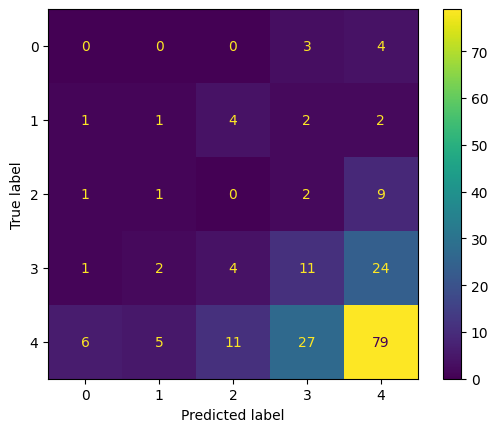

In [71]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calculate the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()


### **d. Repeat tasks 5a-c with SVD to extract 8 components and build a predictive model. Call it Model-2. Report the confusion matrix of Model-2.**

In [72]:
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

n_SVD = 8
SVD_model = models.LsiModel(DFM_tfidf, id2word=dictionary, num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# convert results into array
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# convert results to data frame
svd_df = pd.DataFrame(svd_array)

# show SVD results - reduced vector representation of the documents
svd_df



c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape

,0,1,2,3,4,5,6,7
0,0.056387,0.016769,-0.019729,-0.007736,0.011074,-0.025418,-0.021494,-0.030277
1,0.186620,-0.058571,-0.008746,-0.041381,0.049400,-0.096224,0.036845,0.067000
2,0.129744,0.095168,0.010307,0.037843,0.029510,0.000949,-0.060307,-0.066836
3,0.079081,-0.075127,-0.065809,0.047096,-0.011554,-0.026805,0.052775,-0.027229
4,0.166172,-0.056496,0.057134,0.017052,0.013884,0.037135,0.036687,-0.038952
...,...,...,...,...,...,...,...,...
995,0.146813,-0.019950,0.125019,0.029745,-0.014766,-0.007549,-0.005013,-0.048554
996,0.091858,0.016099,0.077796,0.137839,-0.048723,0.094067,0.012373,0.012276
997,0.098388,0.058420,0.066016,0.063249,0.067930,0.019711,0.039895,-0.052698
998,0.079209,0.000028,-0.028317,-0.037575,0.044897,-0.044656,-0.009974,-0.009418


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Step 1: Create a new DataFrame with the combined columns
combined_df = pd.DataFrame({'Non-Text Column 1': df['Price'], 'Non-Text Column 2': df['review/helpfulness'], 
                            'Component 1': svd_df[0], 'Component 2': svd_df[1], 'Component 3': svd_df[2], 
                            'Component 4': svd_df[3], 'Component 5': svd_df[4]})

# Step 2: Split the data into input features (X) and target variable (y)
X = combined_df[['Non-Text Column 1', 'Non-Text Column 2', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]
y = df['review/score']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create an instance of the DecisionTreeClassifier model
model_1 = DecisionTreeClassifier()

# Step 5: Fit the model to the training data
model_1.fit(X_train, y_train)

# Step 6: Predict the target variable for the testing data
y_pred = model_1.predict(X_test)

# Step 7: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)



Accuracy: 0.505


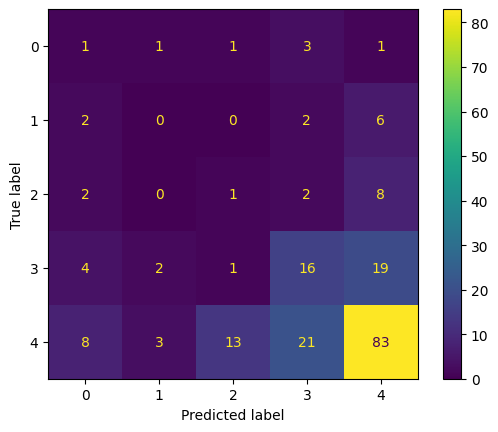

In [74]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calculate the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()


### **e. Which model performs better?  Explain your answer.**